# Costa Rican Household Povety Level Prediction
Using household data to anticipate the level of aid needed by poor families.

## The Problem
Many of the world's poorest and most vulnerable families cannot provide the necessary documentation, e.g., income records, required by government assistance programs. Therefore, governments will often use observable data like a families housing materials, plumbing/electricity situation, and whether they have cell phones to predict their level of need. In Latin America, one popular method is called the Proxy Means Test (PMT). Our task is to try to improve upon existing algorithms and more accurately predict a families need. We will be using data provided by the Inter-American Development Bank containing information about Costa Rican households and their level of poverty measured on an integer scale from 1-4 (1 being the most impoverished). Our algorithm will predict this integer for each household and the quality of our algorithm will be measured by macro F1 score.

## The Data
We are given two data files, <code>train.csv</code> and <code>test.csv</code>. The training set is 9557 rows by 143 columns. Each row represents one person and each person is given an ID called <code>idhogar</code> encoding which household they belong to. The test set is 23856 rows by 142 columns (one less column than the training set because there is no target given).

<b>Note: </b> Although we will be submitting the test data with our prediction for every row, we are evaluated only on our household level prediction. For each person, the boolean variable <code>parentesco1</code> is 1 if that person is the head of the household. Our prediction for this person will be taken to be the household prediction, and each other person in this household will be ignored.

We are not told how the target (income tier 1-4) is calculated. These are supposed to be our ground truth values. Hopefully, they are not the result of running an existing used algorithm on the data, for in this case the competition would be meaningless. You obviously can't hope to improve on a model by training a new one to match the old one as closely as possible. The alternative is that the labels are manually created by the collectors of this data. Without knowing the process, we cannot judge how accurate they are. If there is subjectivity in assigning them, we should expect an inherent amount of noise built into the data.

Lastly, we are not told how the data is collected, so there is the possibility of sampling bias. Perhaps these data are easier to collect for certain households. In a work setting, these uncertainties could potentially be addressed by communicating with the creators of the data. In the present case, however, let's trust the hosts of the competition, and get our best F1 score!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load in the data.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Take a peak train.
pd.set_option('max_columns',None)
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
# Look at the shape of train and test.
print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

train shape: (9557, 143)
test shape: (23856, 142)


In [5]:
# We need to keep a list of Ids in the test set for submission purposes.
submission = test['Id']

## Where do we start?
To remain focused throughout a data science project, we must continually remember the overarching goal. In our case, that is to maximize the F1 score of our model. Thus, every move we make should be in service of that goal.

## Simple working prototype
In his famous machine learning course, Andrew Ng emphasizes the importance of iteration. Instead of thinking about how to build the perfect machine learning system for our problem, we should build a simple prototype as quickly as possible. So our first task will be to get the data in a format that can be fed into a model. We want to do this without significantly modifying our data if possible. That way, we will be able to measure how effective our modifications are by iterating.

Furthermore, once we have a working prototype, we can look at feature importance to narrow down the features that are important to clean and engineer.

## Preparing the data
The minimum work nessecary to get our data into a model generally entails two steps:
1. Addressing missing data
2. Converting non-numeric data

### Missing data

In [6]:
# Display missing train data.
missing_data = pd.DataFrame(train.isna().sum().sort_values(ascending=False)).rename(columns={0:'count'})
missing_data['percent'] = 100 * missing_data['count'] / train.shape[0]
missing_data.head(6)

,count,percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000


There are three columns with significant missing data we must address. We list them here along with the description taken from the data's documentation:

<code>rez_esc</code> Years behind in school<br>
<code>v18q1</code> Number of tablets household owns<br>
<code>v2a1</code> Monthly rent payment

There are also two columns with a trivial amount of missing data, but which still must be handled:

<code>meaneduc</code> average years of education for adults (18+)<br>
<code>SQBmeaned</code> Square of meaneduc

Makes sense that these two would have the same number of missing values.

Ideally, <code>train</code> and <code>test</code> should be randomly sampled and so their missingness should follow a similary pattern. Let's double check that that's the case.

In [7]:
# Display missing test data.
missing_data = pd.DataFrame(test.isna().sum().sort_values(ascending=False)).rename(columns={0:'count'})
missing_data['percent'] = 100 * missing_data['count'] / test.shape[0]
missing_data.head(6)

,count,percent
rez_esc,19653,82.381791
v18q1,18126,75.980885
v2a1,17403,72.950201
SQBmeaned,31,0.129946
meaneduc,31,0.129946
public,0,0.000000


Looks good. Now let's address the missing data column by column.

#### rez_esc (years behind in school)
We are given this clarification by the host via the discussion board: "This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. it is capped at 5."

In [8]:
# View rez_esc nulls by age.
null_by_age = pd.DataFrame(train['rez_esc'].isnull().groupby(train['age']).sum()).rename(columns={'rez_esc' : 'null_count'})
null_by_age['percent'] = 100 - 100 * train['rez_esc'].groupby(train['age']).count() / train['rez_esc'].groupby(train['age']).apply(len)
null_by_age.head(25)

,null_count,percent
age,,
0,99.0,100.000000
1,120.0,100.000000
2,116.0,100.000000
3,143.0,100.000000
4,139.0,100.000000
5,134.0,100.000000
6,150.0,100.000000
7,0.0,0.000000
8,0.0,0.000000


The data tell a slightly different story. It looks like there is only data for individuals between 7 and 17 inclusive. The reasoning must be that people outside of this range are not behind in school because they are no longer of school age. Let's capture this by imputing 0 for <code>rez_esc</code> and making a boolean flag for whether a person is between 7 and 17 years old.

We see there is also one case of genuine missingness. A ten year old with no <code>rez_esc</code> value. One is few enough that it won't hurt to impute the median.

In [9]:
for df in [train, test]:
    df.loc[~df['age'].between(7,17),'rez_esc'] = 0 # Set rez_esc to 0 for non-school-aged people.
    df['School_aged'] = df['age'].between(7,17).astype(int)
    df['rez_esc'].fillna(
        df.loc[df['age'].between(7,17),'rez_esc'].median(), inplace=True) # Impute the mean for school-aged.

#### v2a1 (monthly rent payment)
There is a one-hot encoded categorical variable assigning each household to one of five housing types:<br>
<code>tipovivi1</code> own and fully paid house<br>
<code>tipovivi2</code> own, paying in installments<br>
<code>tipovivi3</code> rented<br>
<code>tipovivi4</code> precarious<br>
<code>tipovivi5</code> other (assigned, borrowed)<br>

Perhaps rent payment data is simply missing for those who don't rent.

In [10]:
for housing in ['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']:
    null_percent = train.loc[train[housing]==1, 'v2a1'].isnull().sum() / (train[housing]==1).sum()
    print('Percent null for {}: {}'.format(housing, null_percent))

Percent null for tipovivi1: 1.0
Percent null for tipovivi2: 0.0
Percent null for tipovivi3: 0.0
Percent null for tipovivi4: 1.0
Percent null for tipovivi5: 1.0


Rent payment is only available for those who are paying off a house or renting. We can handle this the same way we did years behind in school. Set the nulls to 0 and construct a boolean flag denoting whether a household is paying rent.

In [11]:
for df in [train, test]:
    df['pays_rent'] = (~df['v2a1'].isna()).astype(int)
    df['v2a1'].fillna(0, inplace=True) # Change nulls to 0.

#### v18q1 (number of tablets household owns)
We have a boolean column, <code>v18q</code>, whose description is "owns a tablet." Perhaps the nulls in <code>v18q1</code> are simply the cases where the household does not own a tablet. We can easily test the theory.

In [12]:
train.loc[train['v18q1'].isna(),'v18q'].sum() # Sum v18q over all entries with null v18q1.

0

In [13]:
train.loc[~train['v18q1'].isna(),'v18q'].mean() # Mean of v18q over all entries without null v18q1.

1.0

<code>v18q1</code> is null precisely when the household doesn't own a table, so our theory holds up. We can simply impute zero in this case.

In [14]:
for df in [train, test]:
    df['v18q1'].fillna(0, inplace=True) # Change nulls to 0

#### meaneduc (average years of education for adults 18+)
This is the last column with missing values. Although less than one percent of the values are missing, it's worth carefully investigating for two reason.
1. Intuitively, education seems likely to be important for anticipating poverty.
2. There is an individual level variable <code>escolari</code> containing total years of schooling. Is <code>meaneduc</code> engineered from this column and, if so, why is there missingness in one but not the other?

First let's investigate whether <code>meaneduc</code> is indeed constructed from <code>escolari</code>.

In [15]:
# Construct a new dataframe containing adult family members to compare meaneduc with our computed mean escolari.
meaneduc_calc = train.loc[train['age'] >= 18,['idhogar','age','escolari','meaneduc']].join(
    train[train['age'] >= 18].groupby('idhogar')['escolari'].mean(), on='idhogar', rsuffix='_mean')

In [16]:
print('meaneduc is not the mean of escolari in {}% of cases'.format(
    100 * (meaneduc_calc['meaneduc'] != meaneduc_calc['escolari_mean']).sum() / meaneduc_calc.shape[0]))

meaneduc is not the mean of escolari in 32.23740392826644% of cases


Our computation does not align that of the dataset in almost a third of cases. Let's manually inspect the disagreements and see if we can notice anything.

In [17]:
meaneduc_calc[meaneduc_calc['meaneduc'] != meaneduc_calc['escolari_mean']].head(10)

,idhogar,age,escolari,meaneduc,escolari_mean
11,bb2094100,18,12,23.000000,11.500000
12,bb2094100,34,11,23.000000,11.500000
15,6893e65ca,19,11,17.000000,8.500000
16,6893e65ca,70,2,17.000000,8.500000
17,6893e65ca,19,11,17.000000,8.500000
18,6893e65ca,50,10,17.000000,8.500000
23,3e16fab89,41,6,10.333333,10.333333
24,3e16fab89,20,13,10.333333,10.333333
25,3e16fab89,40,12,10.333333,10.333333
27,759df0194,69,6,6.666666,6.666667


In some cases, it's just an innocuous floating point rounding error. However, in other cases, the data set's mean education is precisely double the one we computed. Could it simply be that whoever engineered <code>meaneduc</code> did so incorrectly?

Let's see how our computed column correlates with the target relative to <code>meaneduc</code>.

In [18]:
train[['idhogar','escolari','meaneduc','Target']].join(
    train[train['age'] >= 18].groupby('idhogar')['escolari'].mean(), on='idhogar', rsuffix='_mean').corr()

,escolari,meaneduc,Target,escolari_mean
escolari,1.000000,0.520129,0.302305,0.569561
meaneduc,0.520129,1.000000,0.335203,0.889385
Target,0.302305,0.335203,1.000000,0.391729
escolari_mean,0.569561,0.889385,0.391729,1.000000


Both <code>meaneduc</code> and <code>escolari_mean</code> have a higher correlation coefficient with the target than <code>escolari</code> alone. More interesting is that our computed column correlates better with the target than the one that came with the data. This is evidence to support our suspicion that <code>meaneduc</code> was computed incorrectly. Let's replace <code>meaneduc</code> with our computation.

In [19]:
# Compute meaneduc ourselves.
train.drop(columns=['meaneduc'],inplace=True)
train = train.join(train[train['age'] >= 18].groupby('idhogar')['escolari'].mean(), on='idhogar', rsuffix='_mean')
train.rename(columns={'escolari_mean' : 'meaneduc'},inplace=True)

train['SQBmeaned'] = train['meaneduc']**2 # Recompute the square of meaneduc

In [20]:
# Repeat for the test set.
test.drop(columns=['meaneduc'],inplace=True)
test = test.join(test[test['age'] >= 18].groupby('idhogar')['escolari'].mean(), on='idhogar', rsuffix='_mean')
test.rename(columns={'escolari_mean' : 'meaneduc'},inplace=True)

test['SQBmeaned'] = test['meaneduc']**2

### Rechecking for missing data
Now that we've addressed all of the missing data, let's ensure that our data is complete.

In [21]:
# Display missing train data.
missing_data = pd.DataFrame(train.isna().sum().sort_values(ascending=False)).rename(columns={0:'count'})
missing_data['percent'] = 100 * missing_data['count'] / train.shape[0]
missing_data.head()

,count,percent
meaneduc,15,0.156953
SQBmeaned,15,0.156953
abastaguano,0,0.000000
sanitario3,0,0.000000
sanitario2,0,0.000000


We still have missing data in <code>meaneduc</code>. In fact it's gone up!

Why would averaging <code>escolari</code> over adults within households result in nulls? The first thing that comes to mind is that there are some households with no adults.

In [22]:
train.loc[train['meaneduc'].isna(),['idhogar','age','parentesco1']]

,idhogar,age,parentesco1
4975,896fe6d3e,16,0
5396,374ca5a19,10,0
6443,bfd5067c2,7,0
6444,bfd5067c2,13,0
7461,f2bfa75c4,9,0
7462,f2bfa75c4,10,0
7463,f2bfa75c4,11,0
7705,03c6bdf85,11,0
7706,03c6bdf85,9,0
7756,ad687ad89,16,0


Indeed, the nulls in <code>meaneduc</code> are the result of households with no adults. Furthermore, these households do not possess a designated head (recall that <code>parentesco1</code> is 1 for heads of household). This is alarming when we remember that our model is supposed to assign households to poverty levels, where the correct label is the value of the <code>Target</code> column for the head of household.

Are these genuinely households without a head? Or is the dataset missing individual entries for these households? Let's compare the number of entries per household to the household size listed in the data. Confusingly, there are five different columns that seem to count the number of household members:

<code>r4t3</code> total persons in the household<br>
<code>tamhog</code> size of the household<br>
<code>tamviv</code> number of persons living in the household<br>
<code>hhsize</code> household size<br>
<code>hogar_total</code> # of total individuals in the household<br>

In [23]:
train.loc[train['meaneduc'].isna(),['idhogar','age','r4t3','tamhog','tamviv','hhsize','hogar_total']]

,idhogar,age,r4t3,tamhog,tamviv,hhsize,hogar_total
4975,896fe6d3e,16,4,4,4,4,4
5396,374ca5a19,10,5,5,5,5,5
6443,bfd5067c2,7,4,4,4,4,4
6444,bfd5067c2,13,4,4,4,4,4
7461,f2bfa75c4,9,6,6,6,6,6
7462,f2bfa75c4,10,6,6,6,6,6
7463,f2bfa75c4,11,6,6,6,6,6
7705,03c6bdf85,11,5,5,5,5,5
7706,03c6bdf85,9,5,5,5,5,5
7756,ad687ad89,16,5,5,5,5,5


Each adultless household is the result of incomplete data. Fortunately, there are few enough that we can through them out without losing too much.

In [24]:
# Remove the rows with missing data.
# At this point the only missing data is in meaneduc and we now that these are households with missing members.
for df in [train,test]:
    df.dropna(inplace=True)

The five columns containing household size are identical in this small subset of the data. Are the identical on the entire dataset? This is a rabbit hole worth pursuing. We want to have an accurate count of the number of household members so we can be sure we have all of the data per household. This is especially true since we are working on a household level classification task.

### Determining household size
Why are there five columns that measure household size?

In [25]:
train[['r4t3','tamhog','tamviv','hhsize','hogar_total']].corr()

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998106,0.945215,0.998106,0.998106
tamhog,0.998106,1.000000,0.943611,1.000000,1.000000
tamviv,0.945215,0.943611,1.000000,0.943611,0.943611
hhsize,0.998106,1.000000,0.943611,1.000000,1.000000
hogar_total,0.998106,1.000000,0.943611,1.000000,1.000000


Three of the columns are literally identical: <code>tamhog</code>, <code>hhsize</code>, and <code>hogar_total</code>. Let's drop two and keep one.

In [26]:
for df in [train,test]:
    df.drop(columns=['tamhog','hhsize'],inplace=True)

In [27]:
train[['r4t3','tamviv','hogar_total']].corr()

,r4t3,tamviv,hogar_total
r4t3,1.000000,0.945215,0.998106
tamviv,0.945215,1.000000,0.943611
hogar_total,0.998106,0.943611,1.000000


Reading the descriptions, <code>tamviv</code> is actually slightly different than number of household members. It represents the number of people living in a household. Maybe friends and family temporarily staying. The number of people living in a house that aren't technically members of the household is something we could consider in the feature engineering section of our project.

<code>r4t3</code> and <code>hogar_total</code> on the other hand purport to measure the same thing. In addition, each of these two columns are aggregates of other columns which count the number of members by age and gender:

| Name   | Description                        | Name   | Description                        |
| --- | --- | --- | --- |
| `r4h1` | Males younger than 12 years of age |   `hogar_nin` | Number of children 0 to 19 in household |
| `r4h2` | Males 12 years of age and older    |   `hogar_adul` | Number of adults in household |
| `r4h3` | Total males in the household       |   `hogar_mayor` | hogar_mayor	# of individuals 65+ in the household |
| `r4m1` | Females younger than 12 years of age |   `hogar_total` | hogar_total	# of total individuals in the household |
| `r4m2` | Females 12 years of age and older  |  |  
| `r4m3` | Total females in the household     |  | 
| `r4t1` | persons younger than 12 years of age |    |
| `r4t2` | persons 12 years of age and older  |  | 
| `r4t3` | Total persons in the household     |  |  

In [28]:
train.loc[train['r4t3'] != train['hogar_total'],
          ['idhogar','age','r4h1','r4h2','r4m1','r4m2','r4t3','hogar_nin','hogar_adul','hogar_mayor','hogar_total']]

,idhogar,age,r4h1,r4h2,r4m1,r4m2,r4t3,hogar_nin,hogar_adul,hogar_mayor,hogar_total
497,57d87865e,74,0,0,0,3,3,0,1,1,1
640,1d644ed80,11,1,0,1,2,4,2,1,0,3
641,1d644ed80,41,1,0,1,2,4,2,1,0,3
642,1d644ed80,4,1,0,1,2,4,2,1,0,3
1034,fd80dfac4,84,0,0,0,2,2,0,1,1,1
1054,35e03f915,42,0,1,0,2,3,1,1,0,2
1055,35e03f915,14,0,1,0,2,3,1,1,0,2
1231,b110e9c10,25,0,6,0,1,7,0,4,0,4
1232,b110e9c10,40,0,6,0,1,7,0,4,0,4
1233,b110e9c10,40,0,6,0,1,7,0,4,0,4


Although they disagree with each other, `r4t3` and `hogar_total` are correctly aggregated with one exception: in cases where the only individual in the household is 65+, `hogar_adul`,	`hogar_mayor`, and `hogar_total` are all one. There is an explanation for this. The column after `hogar_total` is called `dependency`. It has the following description:
$$\frac{\text{hogar_mayor} + \text{hogar_nin}}{\text{hogar_adul}}$$

<b>Theory:</b> Whoever engineered `dependency` didn't want it to be infinite, so they set every instance of 0 to 1 in the `hogar_adul` column.

An important observation is that the `hogar` columns seem to be engineered from the current dataset, while the `r4` columns were built before some of the entries within households went missing. We don't want households with incomplete data, and there are few enough households where `hogar_total` $\neq$ `r4t3` that we can drop them without losing too much.

In [29]:
# Drop households with missing members.
train = train[train['r4t3']==train['hogar_total']]

# Repeat for test data.
test = test[test['r4t3']==test['hogar_total']]

Now we only have two columns measuring household size and they agree throughout the data. Hopefully, we've also filtered out the households with incomplete individual-level data. As a sanity check, let's manually count individuals per household and compare.

In [30]:
# Create idhogar_count column in train.
train = train.join(train['idhogar'].value_counts(), on='idhogar', rsuffix='_count')

# Count instances of idhogar_count different than r4t3
(train['r4t3'] != train['idhogar_count']).sum()

35

35 more rows with incomplete individual-level data. Once again, rare enough to safely drop.

In [31]:
# Remove rows where r4t3 and idhogar_count differ
train = train[train['r4t3'] == train['idhogar_count']]
# Drop idhogar_count
train.drop(columns='idhogar_count', inplace=True)

# Repeat for test data
test = test.join(test['idhogar'].value_counts(), on='idhogar', rsuffix='_count')
test = test[test['r4t3'] == test['idhogar_count']]
test.drop(columns='idhogar_count', inplace=True)

In [32]:
print('Total missing values in train data: {}'.format(train.isna().sum().sum()))
print('Total missing values in test data: {}'.format(test.isna().sum().sum()))

Total missing values in train data: 0
Total missing values in test data: 0


No more missing data. Our task is done.

### Missing data summary
1. Made a boolean flag `school_aged` and set `rez_esc` to 0 for non-school-aged individuals.
2. Made a boolean flag for indiviuals who rent their housing and set `v2a1` to 0 for those who don't.
3. Recomputed `meaneduc` and dropped households with no adult (18+).
4. Dropped redundant household counts `tamhog` and `hhsize`.
5. Dropped rows where `hogar_total` $\neq$ `r4t3`.
6. Dropped rows where `r4t3` differs from our manual row count for each `idhogar`.

### Non-numeric data

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9459 entries, 0 to 9556
Columns: 143 entries, Id to meaneduc
dtypes: float64(8), int32(2), int64(128), object(5)
memory usage: 10.3+ MB


There are five non-numeric columns.

In [34]:
train.select_dtypes(object).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


`Id` and `idhogar` can remain objects since they are just identifiers. The other three along with their documentaion:

`dependency` (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)<br>
`edjefe` years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0<br>
`edjefa` years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0<br>

Based on their descriptions, it's not clear how yes/no is a valid option for any of these columns. Let's address them one at a time.

#### dependency

We theorized earlier that this column is engineered from `hogar_nin`, `hogar_adul`, and `hogar_mayor` by the formula

$$\frac{\text{hogar_mayor} + \text{hogar_nin}}{\text{hogar_adul}}.$$

Let's compute this ourselves and compare with `dependency`.

In [35]:
train['dependency_calc'] = (train['hogar_mayor'] + train['hogar_nin']) / train['hogar_adul']

In [36]:
train[['hogar_mayor','hogar_nin','hogar_adul','dependency','dependency_calc']].head()

,hogar_mayor,hogar_nin,hogar_adul,dependency,dependency_calc
0,0,0,1,no,0.0
1,1,0,1,8,1.0
2,1,0,1,8,1.0
3,0,2,2,yes,1.0
4,0,2,2,yes,1.0


At first glance, 'no' seems to correspond to 0 and 'yes' to 1 for some reason. Why is dependency equal to 8 in rows 1 and 2?

Let's replace 'yes' and 'no' with 1 and 0 respectively. Then let's compare the result with our calculation via correlation with the target.

In [37]:
train['dependency'] = pd.to_numeric(train['dependency'].replace({'no' : 0, 'yes' : 1}))
train[['dependency','dependency_calc','Target']].corr()

,dependency,dependency_calc,Target
dependency,1.000000,0.541309,-0.195932
dependency_calc,0.541309,1.000000,-0.398403
Target,-0.195932,-0.398403,1.000000


Our calculated dependency seems to perform much better than the one which came with the data. Perhaps the authors of the data made a mistake in its construction.

In [38]:
# Replace dependency column in train.
train['dependency'] = train['dependency_calc']
train.drop(columns=['dependency_calc'],inplace=True)

# Replace dependency column in test.
test['dependency'] = (test['hogar_mayor'] + test['hogar_nin']) / test['hogar_adul']

#### Handling Infinities
One detail we need to be mindful of is the potential presence of infinities. The formula for `dependency` has a denominator that could potentially be 0, and ML algorithms genernally don't like infinities. Let's search for households where `hogar_adul` = 0.

In [39]:
train.loc[train['hogar_adul'] == 0,['idhogar','age','parentesco1','dependency','Target']]

,idhogar,age,parentesco1,dependency,Target
1291,1b31fd159,18,1,inf,4
1840,a874b7ce7,18,0,inf,4
1841,a874b7ce7,18,1,inf,4
2049,faaebf71a,19,1,inf,4
2050,faaebf71a,19,0,inf,4


These are cases of 18/19 year olds living alone and with roommates. A dependency of 0 seems reasonable in these cases. Also, intuitively, low dependency will likely correlate inversely with poverty, and each of these cases have a target of 4 (non-vulnerable households).

In [40]:
# Replace inf with 0 in dependency for train and test.
for df in [train,test]:
    df['dependency'].replace({np.inf : 0}, inplace=True)

#### edjefe/edjefa
`edjefe` and `edjefa` contain the years of education of the male and female head of household respectively. When the head is female, `edjefe` is 'no' and vice versa. We can do this in a more machine friendly manner with two new columns. `male_head` will be 1 if the head is male and 0 if female. `educ_head` will contain the years of education of the head of household regardless of gender.

In [41]:
# This cell takes about 30 seconds to run on a normal laptop.

# Create male_head and educ_head for train
new_columns = train[['idhogar','parentesco1','male','escolari']].groupby('idhogar').apply(
    lambda x: x.loc[x['parentesco1']==1,['male','escolari']])
new_columns.rename(columns={'male' : 'male_head', 'escolari' : 'educ_head'}, inplace=True)
new_columns.index = new_columns.index.droplevel(1)
train = train.join(new_columns,on='idhogar')

# Create male_head educ_head for test
new_columns = test[['idhogar','parentesco1','male','escolari']].groupby('idhogar').apply(
    lambda x: x.loc[x['parentesco1']==1,['male','escolari']])
new_columns.rename(columns={'male' : 'male_head', 'escolari' : 'educ_head'}, inplace=True)
new_columns.index = new_columns.index.droplevel(1)
test = test.join(new_columns,on='idhogar')

In [42]:
# Drop edjefe/edjefa
for df in [train,test]:
    df.drop(columns=['edjefe','edjefa'],inplace=True)

### Object column summary
1. Recomputed `dependency`.
2. Converted `edjefe` and `edjefa` into `male_head` and `educ_head`.

## Simple working prototype
Now that we've handled all of the missing and non-numeric data, we can feed our dataset into a baseline model.

### Houshold versus individual features
There is one more obstacle we must deal with before constructing our baseline. Recall that we are being evaluated on our ability to predict household need. However, each row in our data represents an individual. Therefore, we must identify which columns vary within households and decide how to feed them into our model.

In [43]:
# Identify which columns vary within households.
nunique_by_hh = train.groupby('idhogar').nunique().max()
multivalue_columns = nunique_by_hh[nunique_by_hh>1].index
multivalue_columns

Index(['Id', 'escolari', 'rez_esc', 'dis', 'male', 'female', 'estadocivil1',
       'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',
       'estadocivil6', 'estadocivil7', 'parentesco1', 'parentesco2',
       'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6',
       'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10',
       'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2',
       'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7',
       'instlevel8', 'instlevel9', 'age', 'SQBescolari', 'SQBage', 'agesq',
       'Target', 'School_aged'],
      dtype='object')

`Id` is an individual identifier and can be dropped. `SQBescolari`, `SQBage`, and `agesq` are merely the squares of other columns. These can be dropped as well since most modern high performing ML algorithms, like random forest and gradient boosted trees, are invariant with respect to monotone transformations. If necessary, we can easily reconstruct them later.

The other columns are potentially important individual features. In the spirit of iteration and professor Ng's simplest working prototype, let's build a model using the household features before we decide how to include the individual ones.

In [44]:
# Drop squared columns from train, and test.
for df in [train,test]:
    df.drop(columns=['SQBescolari','SQBage','agesq'],inplace=True)
    
# Id must be kept in test due to submission format
train.drop(columns=['Id'],inplace=True)
    
# Update our list of multivalue columns
multivalue_columns = multivalue_columns.drop(['Id','SQBescolari','SQBage','agesq'])

In [45]:
# Build data and labels to be used by baseline.
X = train[train['parentesco1']==1].drop(columns=multivalue_columns)
X.drop(columns='idhogar',inplace=True) # Since we are only keeping heads of household, idhogar is no longer necessary.
y = train.loc[train['parentesco1']==1,'Target']

# Update our list of multivalue columns
multivalue_columns = multivalue_columns.drop(['Target'])

### Comparing models

Which algorithm should we use to construct our baseline? <a href='https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf'>This journal article</a> by Randal Olson from 2018 trained the 13 most popular models on 165 divierse datasets and ranked them according to which models performed the best most often. We will try out the top six. Since we are just building a baseline, we will use sklearn's default hyperparameters and worry about tuning later.
<img src="alg_perform.png" width="600">

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

In [47]:
# Instantiate our models.
models = {
    'Gradient Boosting' : GradientBoostingClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Support Vector' : SVC(),
    'Extra Trees' : ExtraTreesClassifier(),
    'Logistic Regression' : LogisticRegression(),
    'K-Nearest' : KNeighborsClassifier()
}

In [48]:
# In this cell, we will time and cross-validate the six models.
import time
import warnings
np.random.seed(10)

# Ignore FutureWarnings
warnings.filterwarnings('ignore', category = FutureWarning)

# Scale to 0 mean and unit variance to give distance based algorithms a fair shot.
X_scaled = preprocessing.scale(X)

# DataFrame to hold results
model_performance = pd.DataFrame(columns=['model','score'])

# Define macro_f1 score
macro_f1 = make_scorer(f1_score, average = 'macro')

for model in models:
    print('Evaluating {}'.format(model))
    t0 = time.time()
    result = cross_val_score(models[model],X_scaled,y,scoring=macro_f1,cv=10)
    print('Finished after {} seconds'.format(time.time()-t0))
    model_performance = model_performance.append(pd.DataFrame({'model' : model, 'score' : result}))

C:\Users\henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


Evaluating Gradient Boosting
Finished after 68.75378942489624 seconds
Evaluating Random Forest
Finished after 0.9817018508911133 seconds
Evaluating Support Vector


C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\c

Finished after 24.090436697006226 seconds
Evaluating Extra Trees
Finished after 0.9704034328460693 seconds
Evaluating Logistic Regression


C:\Users\henry\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finished after 8.491912603378296 seconds
Evaluating K-Nearest
Finished after 3.4429666996002197 seconds


<b> Note:</b> The reason SVC and logistic regression throw an UndefinedMetricWarning is that, for some folds, these models don't predict a single instance of some labels, making the F1 score for those labels 0.

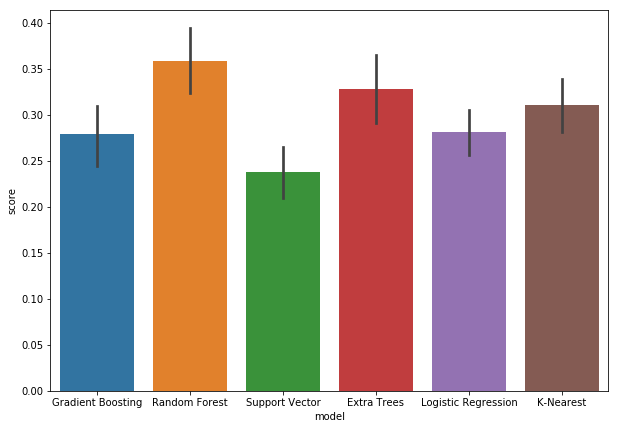

In [49]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='model', y='score', data=model_performance, ax=ax)
plt.show()

Among the untuned models, random forest performs the best and is also the fastest. These two qualities make it ideal for a baseline on which to iterate. Once we are happy with our final dataset, we can tune a variety of models and select the best.

Before feature engineering, let's inspect the predictions of a random forest classifier to see where it struggles. The can help inform our choices.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [51]:
# Train a random forest classifier on 80% of training data.
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred = RandomForestClassifier().fit(X_train,y_train).predict(X_test)

In [52]:
confusion_matrix(y_test, y_pred)

array([[  5,  15,   5,  21],
       [  5,  26,   8,  44],
       [  3,  16,   9,  31],
       [  8,  24,  10, 358]], dtype=int64)

Glancing at the confusion matrix, our model seems to do a good job of separating 4 from 1-3, but can't really discriminate among 1-3. We can confirm this a bit more rigorously by computing F1 score for each class separately.

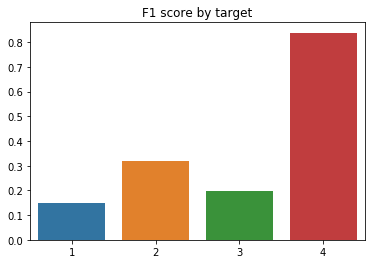

In [53]:
sns.barplot(x=[1,2,3,4],y=f1_score(y_pred,y_test,average=None)).set_title('F1 score by target')
plt.show()

Recall that our goal it to achieve the best possible macro F1 score, which averages each of these one versus all F1 scores. This plot suggests that our efforts would be best spent trying to better distinguish among the first three classes if possible.

### Class Imbalance
This is a good time to explore any class imbalance. It's possible that part of the reason our model is so much better at identifying households in group 4 is that there are so many more examples of it.

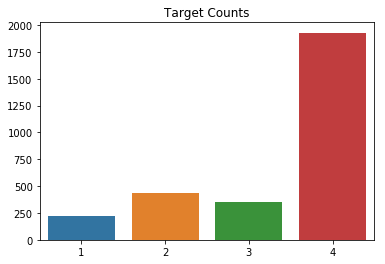

In [54]:
sns.barplot(x=y.value_counts().index, y=y.value_counts().values).set_title('Target Counts')
plt.show()

Surely, it's not a coincidence that this plot closely resembles our F1 score plot by target. There are various ways of addressing class imbalance. Most importantly, you want to be wary of using accuracy as a metric, but that's already taken care of as we are optimizing macro F1 score.

As far improving model performance in the face of class imbalance, our options are limited. According to <a href='https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18'>this guide</a> on dealing with class imbalance, the standard over/undersampling techniques have dubious success. Creating synthetic data, on the other hand, can sometimes help. We want to work big to small, however, and this small optimization would be after we've finished feature engineering and we're tuning our models.

Lastly, one thing to consider is the ordinal nature of our targets. In training classifiers on our data, we are ignoring the fact that 1<2<3<4. This is because we sit somewhere between a regression and a classification problem. It's not quite a classification problem because we have ordindal targets, and it's not quite a regression problem because we have finitely many discrete targets. <a href='https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c'>It is possible to build an ordinal regression model from classifiers</a> and that might be something we want to keep in mind and try when we are tuning our models.

For now, however, let's see how much progress we can make with feature engineering.

## Engineering Features

### Individual features

Recall that we still have yet to include the following individual level features into our household level dataset.

In [56]:
multivalue_columns

Index(['escolari', 'rez_esc', 'dis', 'male', 'female', 'estadocivil1',
       'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',
       'estadocivil6', 'estadocivil7', 'parentesco1', 'parentesco2',
       'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6',
       'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10',
       'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2',
       'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7',
       'instlevel8', 'instlevel9', 'age', 'School_aged'],
      dtype='object')

#### Numeric features
`escolari`, `rez_esc`, and `age` are numeric features that can be aggregated at the household level using standard summary functions like mean and standard deviation. It may also be informative to look at the number of `rez_esc` above zero (how many family members are behind in school). `instlevelX` represents highest level of education and is actually an ordinal variable that's been one-hot encoded. We will want to reverse this encoding to recover the ordinal structure and we can aggregate the result as well.

#### Categorical features
The rest are categorical features. Let's aggregate by mean and sum to count the proportion of and total members in each category respectively.

`female` can be dropped because it's perfectly captured by `male`.

#### Aggregating
We should write a function that performs all of these aggregations so that we don't need to write redundant code for `train` and `test` separately.

In [57]:
def agg_ind_features(df):
    # Reverse one-hot on instlevel
    df['instlevel'] = np.nan
    for i in range(1,10):
        df.loc[df['instlevel'+str(i)]==1, 'instlevel'] = i
        df.drop(columns=['instlevel'+str(i)], inplace=True)
        df['instlevel'].fillna(0,inplace=True) # Turns out rows without instlevel have 0 escolari
    
    # Aggregate numerical columns
    for num_col in ['rez_esc','escolari','instlevel','age']:
        aggs = df.groupby('idhogar')[num_col].agg(['min','max','mean','std']).rename(
                columns={'min' : num_col+'-min',
                        'max' : num_col+'-max',
                        'mean' : num_col+'-mean',
                        'std' : num_col+'-std'})
        df = df.join(aggs, on='idhogar')
        df.fillna(0,inplace=True) # Take std of a single point to be 0
        
    # Count number of positive rez_esc.
    df = df.join(df[df['rez_esc']>0].groupby('idhogar')['rez_esc'].count(),
               on='idhogar', rsuffix='-positive_count').fillna(0)
    
    df.drop(columns=['female'],inplace=True) # Female is redundant
    
    # Aggregate categorical columns
    cat_cols = ['parentesco'+str(i) for i in range(2,13)] + ['estadocivil'+str(i) for i in range(1,8)] + ['dis','male']
    for cat_col in cat_cols:
        aggs = df.groupby('idhogar')[cat_col].agg(['mean','sum']).rename(
                columns={'mean' : cat_col+'-mean',
                        'sum' : cat_col+'-sum'})
        df = df.join(aggs, on='idhogar')
        
    return df

In [58]:
train = agg_ind_features(train)
test = agg_ind_features(test)

### Household features
Having aggregated individual features, all of our data is usable by our model. However, before retraining, let's look for feature engineering opportunities among the household level features.

Like with `instlevelX`, there are one-hot encoded ordinal features, namely, `eparedX`, `etecho`, and `evivX`.

This is also a good opportunity to try our `tamviv` - `hogar_total` idea to capture the diffence between individuals living in a household and household size.

Lastly, <a href='https://www.kaggle.com/skooch/xgboost'>this notebook</a> has some excellent ideas for density-based features by forming ratios of household features. We will implement those features as well.

In [59]:
def engineer_hh_features(df):
    
    # Ordinalize
    for col_name in ['epared','etecho','eviv']:
        for i in range(1,4):
            df.loc[df[col_name+str(i)]==1, col_name] = i
            df.drop(columns=[col_name+str(i)], inplace=True)
            
    # Build tamviv-hogar_total
    df['tamviv-hogar_total'] = df['tamviv'] - df['hogar_total']
    
    # Construct density based features
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                     ('working_man_fraction', 'r4h2', 'r4t3'),
                     ('all_man_fraction', 'r4h3', 'r4t3'),
                     ('human_density', 'tamviv', 'rooms'),
                     ('human_bed_density', 'tamviv', 'bedrooms'),
                     ('rent_per_person', 'v2a1', 'r4t3'),
                     ('rent_per_room', 'v2a1', 'rooms'),
                     ('mobile_density', 'qmobilephone', 'r4t3'),
                     ('tablet_density', 'v18q1', 'r4t3'),
                     ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                     ('tablet_adult_density', 'v18q1', 'r4t2'),
                    ]
    for feat in feats_div:
        df[feat[0]] = df[feat[1]] / df[feat[2]]
        
    return df

In [60]:
train = engineer_hh_features(train)
test = engineer_hh_features(test)

## Building the final model
With the complete, clean dataset in hand, let's see if we have improved over our baseline.

In [61]:
# Rebuild X with new data.
X = train[train['parentesco1']==1].drop(columns=['idhogar','Target'])

In [62]:
# Train a random forest on the new data and append the result to our model_performance dataframe.
np.random.seed(10)
t0 = time.time()
scores = cross_val_score(RandomForestClassifier(), X, y, scoring=macro_f1, cv=10)
print('Scores computed in {} seconds'.format(time.time()-t0))
model_performance = model_performance.append(pd.DataFrame({'model' : 'Random Forest 2', 'score' : scores}))

Scores computed in 1.410681962966919 seconds


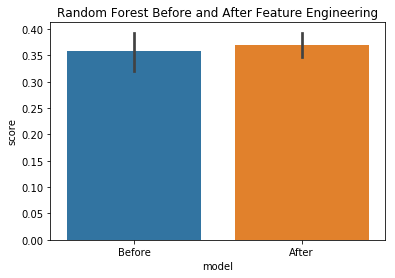

In [63]:
sns.barplot(x='model',y='score',
            data=model_performance[model_performance['model'].isin(['Random Forest','Random Forest 2'])] \
            .replace({'Random Forest' : 'Before', 'Random Forest 2' : 'After'})
           ).set_title('Random Forest Before and After Feature Engineering')
plt.show()

The mean and variance of cross validated F1 scores have improved. This is good news indeed, but as we can see for the nested 95% confidence intervals, we can't be overly confident that there is statistical signal in this comparison.

We can perform a quick t-test to check the significance of the improvement (caveat: assumes crossval scores are normally distributed).

In [64]:
from scipy.stats import ttest_ind
ttest_ind(model_performance.loc[model_performance['model']=='Random Forest','score'],
          model_performance.loc[model_performance['model']=='Random Forest 2','score'])

Ttest_indResult(statistic=-0.4979092387014536, pvalue=0.6245763779011095)

An unimpressive pvalue. We could argue for a one tailed test here, and cut that pvalue in half, but even half is not significant.

### Tuning Hyperparameters
Another step we could take to increase our score is tuning the hyperparameters of our model.

For random forests, the most important dial we can turn is the number of trees. Random forest is a bagging algorithm - it builds a bunch of high variance weak estimators and then averages them. The process of averaging creates a low variance model. The more trees we build, the lower the variance, but the higher the computation time and there are diminishing returns. In <a href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'>sklearn's implementation</a>, the parameter is called `n_estimators`. Let's see how increasing this parameter affects our model.

In [65]:
# This cell takes 2-3 minutes on a normal laptop.
np.random.seed(10)

# We use an exponential scale for our grid.
n_estimators_grid = [10,20,40,80,160,320,640]

# DataFrame to hold results
n_estimators_performance = pd.DataFrame(columns=['n_estimators','score'])

for n_estimators in n_estimators_grid:
    print('n_estimators = {}'.format(n_estimators))
    t0 = time.time()
    result = cross_val_score(RandomForestClassifier(n_estimators=n_estimators),X,y,scoring=macro_f1,cv=10)
    print('Finished after {} seconds.'.format(time.time()-t0))
    n_estimators_performance = n_estimators_performance.append(pd.DataFrame({'n_estimators' : n_estimators, 'score' : result}))

n_estimators = 10
Finished after 1.451390266418457 seconds.
n_estimators = 20
Finished after 2.5607614517211914 seconds.
n_estimators = 40
Finished after 5.070632696151733 seconds.
n_estimators = 80
Finished after 9.478331804275513 seconds.
n_estimators = 160
Finished after 19.372814178466797 seconds.
n_estimators = 320
Finished after 38.21204710006714 seconds.
n_estimators = 640
Finished after 76.59836673736572 seconds.


We see the drawback in adding trees in the computation time, which appears to increase linearly in `n_estimators`. This makes sense. It takes twice as long to build twice as many trees. What do the scores look like?

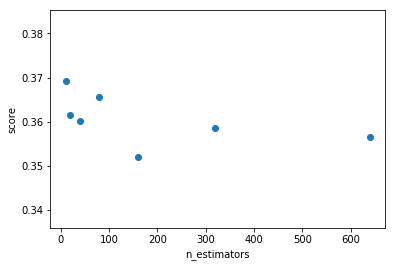

In [66]:
plt.scatter(x=n_estimators_performance.groupby('n_estimators').mean().index,
           y=n_estimators_performance.groupby('n_estimators').mean().values)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

There actually seems to be a downward trend, although this is likely just noise. The graph might be a bit misleading since we are plotting means, and there may be more variance within each sample than among the different `n_estimator` settings. Also, the y-axis doesn't start at 0, making the spread look more pronounced.

Let's build a seaborn barplot with confidence intervals so we can see within sample variance too. Also, we will make the score axis start from 0.

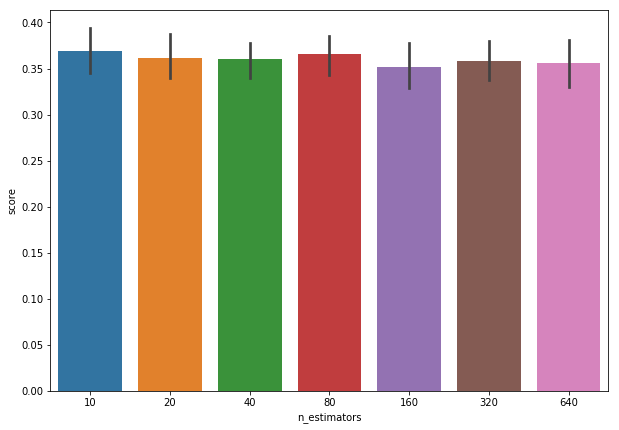

In [67]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='n_estimators', y='score', data=n_estimators_performance, ax=ax)
plt.show()

This visualization makes the noise theory seem likely.

Main takeaway: `n_estimators`=10 is adequate for our problem.

Some other random forest hyperparameters we can tune:
`max_features` The number of features to consider when looking for the best split. <br>
`max_depth` The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. <br>
`min_samples_split` The minimum number of samples required to split an internal node. <br>
`min_samples_leaf` The minimum number of samples required to be at a leaf node. <br>
`bootstrap` Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree. <br>

We will use sklearn's `RandomizedSearchCV` class to perform a random grid search on these parameters. The search grid is suggested in <a href='https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74'>this article</a> by Will Koehrsen.

In [68]:
from sklearn.model_selection import RandomizedSearchCV
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

This parameter grid has $2*11*3*3*2=396$ points. Roughly speaking, the size of your grid is exponential in the number of parameters you are simultaneously considering. The beauty of a random grid search is you don't have to crunch through every possible combination of parameters.

In [69]:
t0=time.time()
rf = RandomForestClassifier(n_estimators=10)
rf_random = RandomizedSearchCV(scoring = macro_f1, estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 10, random_state=10, n_jobs = -1)
rf_random.fit(X, y)
print('Random grid search took {} seconds.'.format(time.time()-t0))

Random grid search took 41.16365194320679 seconds.


In [70]:
# The parameters that produced the best score.
rf_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

Let's do a 10 fold cross validation on a random forest with these parameters and compare with our untuned model.

In [71]:
# Train a random forest with tuned parameters and add result to performance dataframe.
np.random.seed(10)
t0 = time.time()
rfc = RandomForestClassifier(min_samples_split = 10, min_samples_leaf = 1, max_features = 'sqrt',
                             max_depth = 60, bootstrap = False)
scores = cross_val_score(rfc, X, y, scoring=macro_f1, cv=10)
print('Scores computed in {} seconds'.format(time.time()-t0))
model_performance = model_performance.append(pd.DataFrame({'model' : 'Random Forest 3', 'score' : scores}))

Scores computed in 1.7740323543548584 seconds


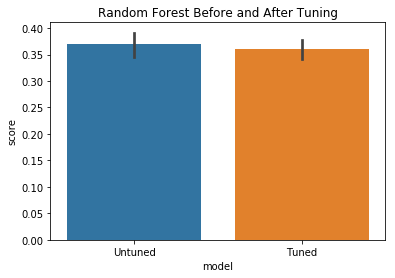

In [72]:
# Compare with untuned model.
sns.barplot(x='model',y='score',
            data=model_performance[model_performance['model'].isin(['Random Forest 2','Random Forest 3'])] \
            .replace({'Random Forest 2' : 'Untuned', 'Random Forest 3' : 'Tuned'})
           ).set_title('Random Forest Before and After Tuning')
plt.show()

The tuned model actually has a lower average score than the untuned one. Once again, this is probably just the result of noise as we can see from the overlapping confidence intervals.

If any improvements have been made since the baseline model, they are fairly insignficant

This seems to be a theme in machine learning. Once you have a reasonable working baseline up and running, and additional improvements will be small and come with hard work. See the <a href='https://en.wikipedia.org/wiki/Pareto_principle'>80/20 rule</a>.

## Submission
If you want to submit to the Kaggle contest, run the following cell. It will save `submission.csv` to the current directory in a format that is acceptable to the Kaggle evaluator.

In [73]:
# Predict on test housholds.
y_pred = rfc.fit(X,y).predict(test[test['parentesco1']==1].drop(columns=['idhogar','Id']))
# Doesn't matter what non-household-heads are.
test['Target'] = np.nan
test.loc[test['parentesco1']==1,'Target'] = y_pred
submission = pd.DataFrame(submission).set_index(keys='Id').join(test[['Id','Target']].set_index(keys='Id'))
submission = submission.fillna(1).astype(int)
submission.to_csv('submission.csv')

### Next Steps
Submitting our solution to the Kaggle evaluator results in a macro F1 score of .372. While this certainly leaves something to be desired, there is definitely a <a href='https://en.wikipedia.org/wiki/Bayes_error_rate'>limit</a> to what we can do with the data we have. We addressed these concerns in the introduction to this notebook.

However, there are always addition things that can be tried. Here are a couple of ideas:

- Try the ordinal regression idea.
- Train a gradient boosted tree with LightGBM. Gradient boosted trees seem to win most Kaggle supervised learning contests on structured data and LightGBM is a popular implementation due to its speed and power.
- Try building synthetic data to address class imbalance.